# Adding Zones and Zone Scores to Census Tracts 

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shapely
from shapely.geometry.point import Point
import geopandas as gpd

In [39]:
# load in census data from 'clean_data' folder
den = gpd.read_file('../data/clean_data/flood_vulnerability.json')
den.head()

ST     STATE ST_ABBR STCNTY      COUNTY         FIPS  \
0  08  COLORADO      CO  08001       Adams  08001988700   
1  08  COLORADO      CO  08014  Broomfield  08014980100   
2  08  COLORADO      CO  08014  Broomfield  08014980200   
3  08  COLORADO      CO  08014  Broomfield  08014980300   
4  08  COLORADO      CO  08031      Denver  08031980100   

                                         LOCATION  AREA_SQMI  E_TOTPOP  \
0       Census Tract 9887, Adams County, Colorado  26.079290       0.0   
1  Census Tract 9801, Broomfield County, Colorado   0.043224       0.0   
2  Census Tract 9802, Broomfield County, Colorado   0.152955       0.0   
3  Census Tract 9803, Broomfield County, Colorado   0.040641       0.0   
4      Census Tract 9801, Denver County, Colorado   1.663264       0.0   

   M_TOTPOP  RPL_THEMES  SPL_THEMES  min_elevation  med_elevation  \
0      11.0         0.0      -999.0    1572.611450    1597.951477   
1      11.0         0.0      -999.0    1596.278809    1607.702271   
2      11.0         0.0      -999.0    1586.879028    1598.008606   
3      11.0         0.0      -999.0    1610.245972    1622.763245   
4      11.0         0.0      -999.0    1605.578735    1613.646973   

   avg_elevation  local_median  local_minimum  local_median_diff  \
0    1596.041547   1572.611450    1572.611450           0.000000   
1    1605.785358   1596.278809    1558.163940           0.000000   
2    1597.971259   1586.879028    1558.163940           0.000000   
3    1621.013385   1610.245972    1583.744507           0.000000   
4    1612.583514   1611.795044    1591.373901          -6.216309   

   local_min_diff                                           geometry  
0        0.000000  POLYGON ((-104.90354 39.80567, -104.90355 39.8...  
1       38.114868  POLYGON ((-105.10667 39.95783, -105.10737 39.9...  
2       28.715088  POLYGON ((-105.08869 39.95842, -105.08722 39.9...  
3       26.501465  POLYGON ((-105.12126 39.95239, -105.11439 39.9...  
4       14.204834  POLYGON ((-104.86639 39.79769, -104.86604 39.7...

In [68]:
# load in the zone coordinates from 'clean_data' folder
zone_centriods = pd.read_csv('../data/clean_data/zone_coordinates.csv')
zone_centriods

cluster   latitude   longitude
0        0  39.548613 -104.771038
1        1  39.713901 -104.936533
2        2  39.742213 -105.109631
3        3  39.960952 -105.119310
4        4  40.026365 -105.281491

In [90]:
# define function to replicate the zones (circle with radius ~6.9 miles)
# and checks if point falls within zone
def is_in_zone(census_center,center_lng,center_lat):
    p = Point([center_lng, center_lat])
    circle = p.buffer(.1)
    test_point = census_center
    return circle.contains(test_point)


In [93]:
#test function
is_in_zone(den['geometry'][0].centroid,zone_centriods['longitude'][0],zone_centriods['latitude'][0])

False

In [102]:
# function for determining census tract in each zone, 
# finds the centriod of the census tract and evaluates whether or not it falls within the zone 'circle'
def assign_zone_to_census(data_df,zones_df):
    df = data_df.copy()
    df['zone'] = 20 
    for z in range(len(zones_df)):

        for p in range(len(data_df)):
            result = is_in_zone(data_df.centroid.loc[p],zones_df.loc[z]['longitude'],zones_df.loc[z]['latitude'])         
            if result == True and df['zone'].loc[p] == 20:
                df['zone'].loc[p] = z

    return df

In [104]:
# overwrite the df with the new zone data
den = assign_zone_to_census(den,zone_centriods)

In [105]:
# view changes
den.head()

ST     STATE ST_ABBR STCNTY      COUNTY         FIPS  \
0  08  COLORADO      CO  08001       Adams  08001988700   
1  08  COLORADO      CO  08014  Broomfield  08014980100   
2  08  COLORADO      CO  08014  Broomfield  08014980200   
3  08  COLORADO      CO  08014  Broomfield  08014980300   
4  08  COLORADO      CO  08031      Denver  08031980100   

                                         LOCATION  AREA_SQMI  E_TOTPOP  \
0       Census Tract 9887, Adams County, Colorado  26.079290       0.0   
1  Census Tract 9801, Broomfield County, Colorado   0.043224       0.0   
2  Census Tract 9802, Broomfield County, Colorado   0.152955       0.0   
3  Census Tract 9803, Broomfield County, Colorado   0.040641       0.0   
4      Census Tract 9801, Denver County, Colorado   1.663264       0.0   

   M_TOTPOP  ...  SPL_THEMES  min_elevation  med_elevation  avg_elevation  \
0      11.0  ...      -999.0    1572.611450    1597.951477    1596.041547   
1      11.0  ...      -999.0    1596.278809    1607.702271    1605.785358   
2      11.0  ...      -999.0    1586.879028    1598.008606    1597.971259   
3      11.0  ...      -999.0    1610.245972    1622.763245    1621.013385   
4      11.0  ...      -999.0    1605.578735    1613.646973    1612.583514   

   local_median  local_minimum  local_median_diff  local_min_diff  \
0   1572.611450    1572.611450           0.000000        0.000000   
1   1596.278809    1558.163940           0.000000       38.114868   
2   1586.879028    1558.163940           0.000000       28.715088   
3   1610.245972    1583.744507           0.000000       26.501465   
4   1611.795044    1591.373901          -6.216309       14.204834   

                                            geometry zone  
0  POLYGON ((-104.90354 39.80567, -104.90355 39.8...   20  
1  POLYGON ((-105.10667 39.95783, -105.10737 39.9...    3  
2  POLYGON ((-105.08869 39.95842, -105.08722 39.9...    3  
3  POLYGON ((-105.12126 39.95239, -105.11439 39.9...    3  
4  POLYGON ((-104.86639 39.79769, -104.86604 39.7...   20  

[5 rows x 21 columns]

In [106]:
# count the number of census tracts in each zone (zone 20 is an undefined zone)
den['zone'].value_counts()

20    331
1     145
2      94
3      42
0      41
4      25
Name: zone, dtype: int64

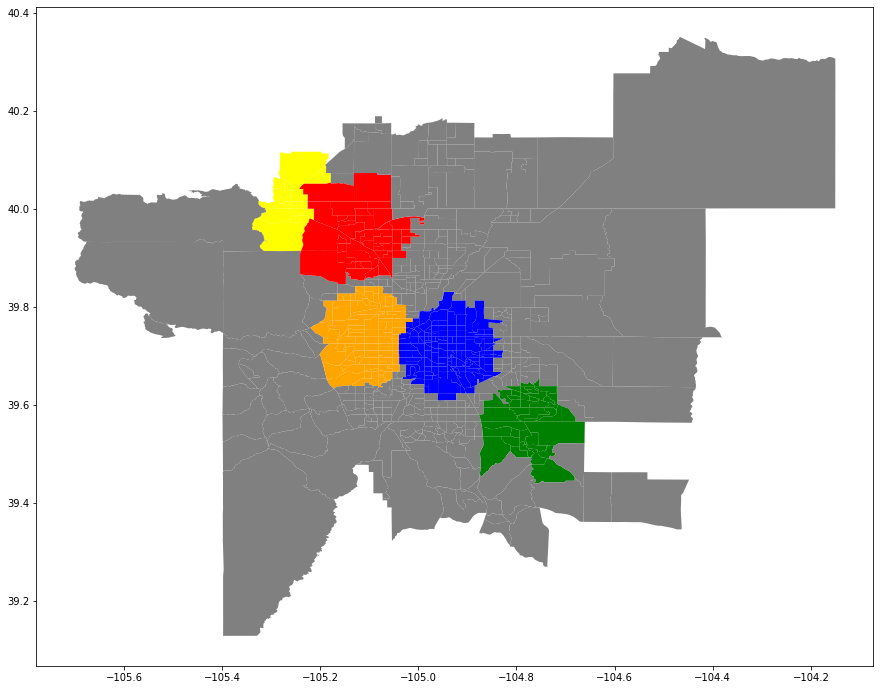

In [227]:
# plot census tracts by zone assignments
colors = den['zone'].map({0: 'green',1 :'blue' ,2:'orange',3:'red',4:'yellow',20:'grey'})
den['geometry'].plot(color = colors,figsize = (15,15))

In [140]:
# find total population by zone
den.groupby(by=['zone'])['E_TOTPOP'].sum()

zone
0      192247.0
1      635798.0
2      378936.0
3      175392.0
4      114560.0
20    1499879.0
Name: E_TOTPOP, dtype: float64

In [157]:
# import zone scores from 'clean_data' folder
scores = pd.read_csv('../data/clean_data/zone_scores.csv')
scores

zone  lifeline_1  lifeline_2  lifeline_3  lifeline_4  lifeline_5  \
0     0          15           8           6           0           0   
1     1         106          91          51           7          19   
2     2          28          21          16           2           3   
3     3          12          13           5           1           0   
4     4          13          11           6           1           2   
5    20         100          95          41           9           6   

   lifeline_6  lifeline_7   score_n  score_n_weighted  score_weighted  
0           2           0  0.149731          0.033395             6.6  
1          65           0  2.598137          0.418175            63.8  
2          13           0  0.605894          0.105195            16.4  
3           5           0  0.221973          0.040016             7.1  
4           5           0  0.291921          0.048139             7.4  
5          58           0  2.132345          0.355080            58.6

In [158]:
# find total of normalized score column
scores['score_n'].sum()

6.0

In [159]:
# add the zone populations to the score df
scores['zone_pop'] = np.array(den.groupby(by=['zone'])['E_TOTPOP'].sum())
scores

zone  lifeline_1  lifeline_2  lifeline_3  lifeline_4  lifeline_5  \
0     0          15           8           6           0           0   
1     1         106          91          51           7          19   
2     2          28          21          16           2           3   
3     3          12          13           5           1           0   
4     4          13          11           6           1           2   
5    20         100          95          41           9           6   

   lifeline_6  lifeline_7   score_n  score_n_weighted  score_weighted  \
0           2           0  0.149731          0.033395             6.6   
1          65           0  2.598137          0.418175            63.8   
2          13           0  0.605894          0.105195            16.4   
3           5           0  0.221973          0.040016             7.1   
4           5           0  0.291921          0.048139             7.4   
5          58           0  2.132345          0.355080            58.6   

    zone_pop  
0   192247.0  
1   635798.0  
2   378936.0  
3   175392.0  
4   114560.0  
5  1499879.0

In [160]:
# add population density column to scores (pop in zone / total pop)
scores['zone_pop_den'] = scores['zone_pop']/scores['zone_pop'].sum()
scores

zone  lifeline_1  lifeline_2  lifeline_3  lifeline_4  lifeline_5  \
0     0          15           8           6           0           0   
1     1         106          91          51           7          19   
2     2          28          21          16           2           3   
3     3          12          13           5           1           0   
4     4          13          11           6           1           2   
5    20         100          95          41           9           6   

   lifeline_6  lifeline_7   score_n  score_n_weighted  score_weighted  \
0           2           0  0.149731          0.033395             6.6   
1          65           0  2.598137          0.418175            63.8   
2          13           0  0.605894          0.105195            16.4   
3           5           0  0.221973          0.040016             7.1   
4           5           0  0.291921          0.048139             7.4   
5          58           0  2.132345          0.355080            58.6   

    zone_pop  zone_pop_den  
0   192247.0      0.064151  
1   635798.0      0.212158  
2   378936.0      0.126446  
3   175392.0      0.058526  
4   114560.0      0.038227  
5  1499879.0      0.500492

In [161]:
#create total normalized score (normalized score * zone poulation density)
scores['total_score_n'] = scores['score_n'] * scores['zone_pop_den']
scores

zone  lifeline_1  lifeline_2  lifeline_3  lifeline_4  lifeline_5  \
0     0          15           8           6           0           0   
1     1         106          91          51           7          19   
2     2          28          21          16           2           3   
3     3          12          13           5           1           0   
4     4          13          11           6           1           2   
5    20         100          95          41           9           6   

   lifeline_6  lifeline_7   score_n  score_n_weighted  score_weighted  \
0           2           0  0.149731          0.033395             6.6   
1          65           0  2.598137          0.418175            63.8   
2          13           0  0.605894          0.105195            16.4   
3           5           0  0.221973          0.040016             7.1   
4           5           0  0.291921          0.048139             7.4   
5          58           0  2.132345          0.355080            58.6   

    zone_pop  zone_pop_den  total_score_n  
0   192247.0      0.064151       0.009605  
1   635798.0      0.212158       0.551216  
2   378936.0      0.126446       0.076613  
3   175392.0      0.058526       0.012991  
4   114560.0      0.038227       0.011159  
5  1499879.0      0.500492       1.067221

In [162]:
# create total weighted score, not normalized (weighted score / zone population)
scores['total_score_weighted'] = scores['score_weighted'] / scores['zone_pop']
scores

zone  lifeline_1  lifeline_2  lifeline_3  lifeline_4  lifeline_5  \
0     0          15           8           6           0           0   
1     1         106          91          51           7          19   
2     2          28          21          16           2           3   
3     3          12          13           5           1           0   
4     4          13          11           6           1           2   
5    20         100          95          41           9           6   

   lifeline_6  lifeline_7   score_n  score_n_weighted  score_weighted  \
0           2           0  0.149731          0.033395             6.6   
1          65           0  2.598137          0.418175            63.8   
2          13           0  0.605894          0.105195            16.4   
3           5           0  0.221973          0.040016             7.1   
4           5           0  0.291921          0.048139             7.4   
5          58           0  2.132345          0.355080            58.6   

    zone_pop  zone_pop_den  total_score_n  total_score_weighted  
0   192247.0      0.064151       0.009605              0.000034  
1   635798.0      0.212158       0.551216              0.000100  
2   378936.0      0.126446       0.076613              0.000043  
3   175392.0      0.058526       0.012991              0.000040  
4   114560.0      0.038227       0.011159              0.000065  
5  1499879.0      0.500492       1.067221              0.000039

In [255]:
scores['total_score_weighted'].describe()

count    6.000000
mean     0.000054
std      0.000025
min      0.000034
25%      0.000039
50%      0.000042
75%      0.000059
max      0.000100
Name: total_score_weighted, dtype: float64

In [230]:
# create standardized score of 'total_score_weighted'(total_score_weighted * 1 / max total_score_weighted)
scores['standard_score'] = scores['total_score_weighted'] * (1 / scores['total_score_weighted'].max())
scores

zone  lifeline_1  lifeline_2  lifeline_3  lifeline_4  lifeline_5  \
0    99          15           8           6           0           0   
1     1         106          91          51           7          19   
2     2          28          21          16           2           3   
3     3          12          13           5           1           0   
4     4          13          11           6           1           2   
5    20         100          95          41           9           6   

   lifeline_6  lifeline_7   score_n  score_n_weighted  score_weighted  \
0           2           0  0.149731          0.033395             6.6   
1          65           0  2.598137          0.418175            63.8   
2          13           0  0.605894          0.105195            16.4   
3           5           0  0.221973          0.040016             7.1   
4           5           0  0.291921          0.048139             7.4   
5          58           0  2.132345          0.355080            58.6   

    zone_pop  zone_pop_den  total_score_n  total_score_weighted  \
0   192247.0      0.064151       0.009605              0.000034   
1   635798.0      0.212158       0.551216              0.000100   
2   378936.0      0.126446       0.076613              0.000043   
3   175392.0      0.058526       0.012991              0.000040   
4   114560.0      0.038227       0.011159              0.000065   
5  1499879.0      0.500492       1.067221              0.000039   

   standard_score  
0        0.342123  
1        1.000000  
2        0.431297  
3        0.403410  
4        0.643720  
5        0.389350

In [231]:
# create function that assigns zone score to each census tract based on zone
def score_to_census(census_df,score_df):
    df = census_df.copy()
    df['zone_score'] = 0
    for s in range(len(score_df)):
        for c in range(len(census_df)):
            if df['zone'].loc[c] == score_df['zone'].loc[s]:
                df['zone_score'].loc[c] = score_df['standard_score'].loc[s]

    return df

In [233]:
# overwrite the df with the new zone score
den_score = score_to_census(den,scores)
den_score.head()

ST     STATE ST_ABBR STCNTY      COUNTY         FIPS  \
0  08  COLORADO      CO  08001       Adams  08001988700   
1  08  COLORADO      CO  08014  Broomfield  08014980100   
2  08  COLORADO      CO  08014  Broomfield  08014980200   
3  08  COLORADO      CO  08014  Broomfield  08014980300   
4  08  COLORADO      CO  08031      Denver  08031980100   

                                         LOCATION  AREA_SQMI  E_TOTPOP  \
0       Census Tract 9887, Adams County, Colorado  26.079290       0.0   
1  Census Tract 9801, Broomfield County, Colorado   0.043224       0.0   
2  Census Tract 9802, Broomfield County, Colorado   0.152955       0.0   
3  Census Tract 9803, Broomfield County, Colorado   0.040641       0.0   
4      Census Tract 9801, Denver County, Colorado   1.663264       0.0   

   M_TOTPOP  ...  min_elevation  med_elevation  avg_elevation  local_median  \
0      11.0  ...    1572.611450    1597.951477    1596.041547   1572.611450   
1      11.0  ...    1596.278809    1607.702271    1605.785358   1596.278809   
2      11.0  ...    1586.879028    1598.008606    1597.971259   1586.879028   
3      11.0  ...    1610.245972    1622.763245    1621.013385   1610.245972   
4      11.0  ...    1605.578735    1613.646973    1612.583514   1611.795044   

   local_minimum  local_median_diff  local_min_diff  \
0    1572.611450           0.000000        0.000000   
1    1558.163940           0.000000       38.114868   
2    1558.163940           0.000000       28.715088   
3    1583.744507           0.000000       26.501465   
4    1591.373901          -6.216309       14.204834   

                                            geometry  zone zone_score  
0  POLYGON ((-104.90354 39.80567, -104.90355 39.8...    20    0.38935  
1  POLYGON ((-105.10667 39.95783, -105.10737 39.9...     3    0.40341  
2  POLYGON ((-105.08869 39.95842, -105.08722 39.9...     3    0.40341  
3  POLYGON ((-105.12126 39.95239, -105.11439 39.9...     3    0.40341  
4  POLYGON ((-104.86639 39.79769, -104.86604 39.7...    20    0.38935  

[5 rows x 22 columns]

In [240]:
den_score['RPL_THEMES'].describe()

count    678.000000
mean       0.444038
std        0.304242
min        0.000000
25%        0.165700
50%        0.403600
75%        0.704000
max        1.000000
Name: RPL_THEMES, dtype: float64

In [236]:
calc = den_score['RPL_THEMES'] - den_score['zone_score']

In [238]:
calc.describe()

count    678.000000
mean      -0.068430
std        0.358507
min       -0.998400
25%       -0.312950
50%       -0.096000
75%        0.203951
max        0.606550
dtype: float64

In [256]:
def calc(row):
    if row['RPL_THEMES'] - row['zone_score'] > .01:
        return row['RPL_THEMES'] - row['zone_score']
    else:
        return .01

In [257]:
den_score['CALC'] = den_score.apply(lambda row: calc(row), axis = 1)

In [258]:
den_score['CALC'].describe()

count    678.000000
mean       0.122241
std        0.175241
min        0.010000
25%        0.010000
50%        0.010000
75%        0.203951
max        0.606550
Name: CALC, dtype: float64

In [263]:
den_score['CALC'].value_counts(normalize=True).sort_index()

0.01000    0.607670
0.01095    0.001475
0.01175    0.001475
0.01665    0.001475
0.01700    0.001475
             ...   
0.59285    0.001475
0.59560    0.001475
0.59845    0.001475
0.60175    0.001475
0.60655    0.001475
Name: CALC, Length: 267, dtype: float64

In [264]:
den_score[den_score['zone_score'] == 1.0][['RPL_THEMES','zone_score','CALC']]

RPL_THEMES  zone_score  CALC
6        0.9854         1.0  0.01
7        0.9976         1.0  0.01
8        0.9417         1.0  0.01
9        0.9408         1.0  0.01
46       0.9992         1.0  0.01
..          ...         ...   ...
658      0.3120         1.0  0.01
659      0.6896         1.0  0.01
660      0.8404         1.0  0.01
661      0.7042         1.0  0.01
663      0.8258         1.0  0.01

[145 rows x 3 columns]

In [287]:
# export test for Megha
den_score[['FIPS','zone','CALC']].to_csv("../data/clean_data/FIPS_test.csv",index = False)

In [321]:
# import in hazard score
final = pd.read_csv('../data/clean_data/hazard_vulnerability.csv',converters={'FIPS': str})
final


hazard  vulnerability         FIPS
0      10.0         0.0000  08001988700
1       7.4         0.0000  08014980100
2       8.0         0.0000  08014980200
3       8.2         0.0000  08014980300
4       9.0         0.0000  08031980100
..      ...            ...          ...
673     7.4         0.9530  08059011601
674    10.0         0.4246  08059012027
675     6.7         0.7253  08059015900
676     6.4         0.0000  08059980400
677    10.0         0.8144  08123001902

[678 rows x 3 columns]

In [334]:
final['zone_score'] = final['FIPS'].apply(lambda x: get_zone_score(x, den_score))

ValueError: Wrong number of items passed 678, placement implies 1

In [333]:
def get_zone_score (x, df):
    for ndx in df['FIPS']:
        if x == ndx:
            return df['zone_score']
    
#    return 0

#final['zone_score'] = den_score['FIPS'] == final['FIPS']

In [331]:
final.shape

(678, 3)

In [ ]:
#export data to 'clean_data' folder
#den_score.to_file("../data/clean_data/census_zone_score.json", driver="GeoJSON")